## Scoring
The target score is accuracy, judging by whether our detector sees the expected vechile and doesn't see others:
- 50% of the score comes from the mentioned vehicles labels
- 50% from other objects, which are not transportation vehicles (e.g., A football stadium, a building etc).

-For this notebook, you are expected to change `model_url` and run it end-to-end. 

The final standing will be judged by a similar script; it may differ in details but will follow the same approach. The detector may not always be precise; for the final standing, we will employ several modifications to alleviate the effect and provide fair judgment.

In [5]:
model_url = "unibuc-cs/ROAITransportationCo_model"

In [ ]:
import importlib

if importlib.util.find_spec('diffusers') is None:
    !pip install diffusers transformers accelerate

In [7]:
import torch
from diffusers import DiffusionPipeline
from transformers import YolosImageProcessor, YolosForObjectDetection
import numpy as np

torch.set_grad_enabled(False)  # disable all gradients, as we do only inference

device = 'cuda'
seed = 42 # Fixed seed to reproduce quickly

vehicle_classes = ["train", "airplane", "boat", "truck", "bus", "others"]

prompts = [
    "A train in the mountains",
    "aiplane just landing on a field",
    "a boat accesorry",
    "People around a truck",
    "passegers are filling a bus",
    "In a snowy forest, a cozy bear stands under snow-covered trees, enjoying the gentle snowfall.",
    "Partially hidden in a dense tropical rainforest, an adventurous sheep peeks through leafy plants.",
    "A sleek sheep with modern accessories navigates a futuristic city with flying cars and neon lights.",
    "Let's a go, Mario!",
    "Winter is coming...",    
]

labels = [0, 1, 2, 3, 4, 5, 5, 5, 5, 5]

In [8]:
pipe = DiffusionPipeline.from_pretrained(
    model_url, torch_dtype=torch.float16, safety_checker=None, requires_safety_checker=False
)
pipe.set_progress_bar_config(disable=True)
pipe.to(device)

def generate(prompt):
    image = pipe(
        prompt=prompt, num_inference_steps=50, guidance_scale=8.5,
        generator=torch.Generator(device=device).manual_seed(seed)
    ).images[0]

    return image

model_index.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/803 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'predict_epsilon': True} were passed to DPMSolverMultistepScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [9]:

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")
model.to(device)

def detect(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
    objects = [model.config.id2label[idx.item()] for idx in results['labels']]
    return objects


C:\Users\cipri\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/26.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

In [10]:
def is_correct(objects, label):
    name = vehicle_classes[label]
    return set(objects).intersection(set(vehicle_classes)) == {name}


C:\Users\cipri\anaconda3\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


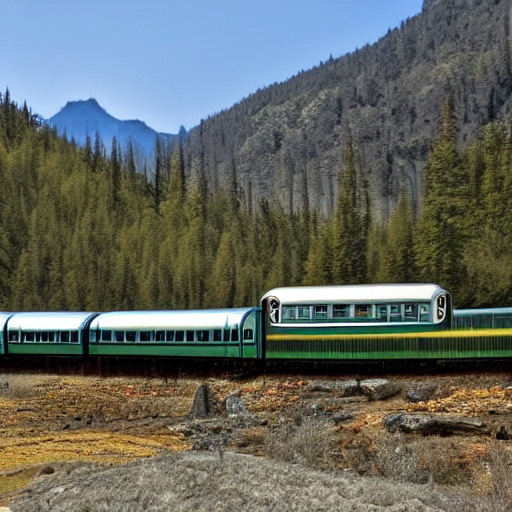

['train']


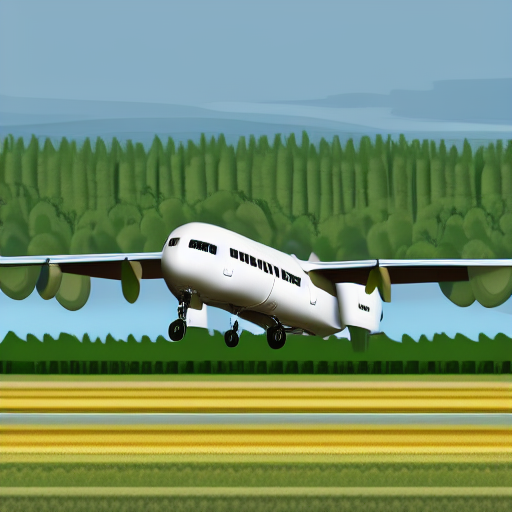

['airplane']


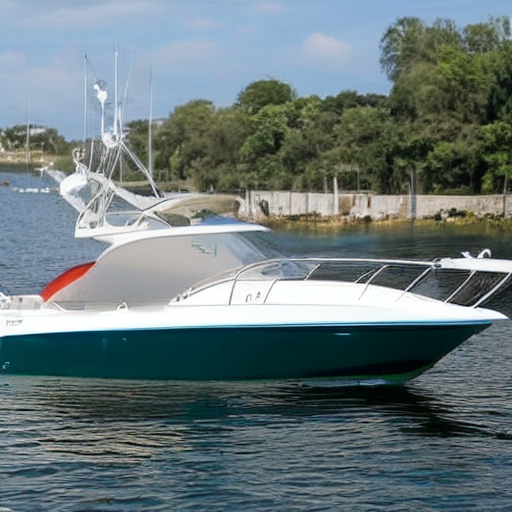

['boat', 'boat']


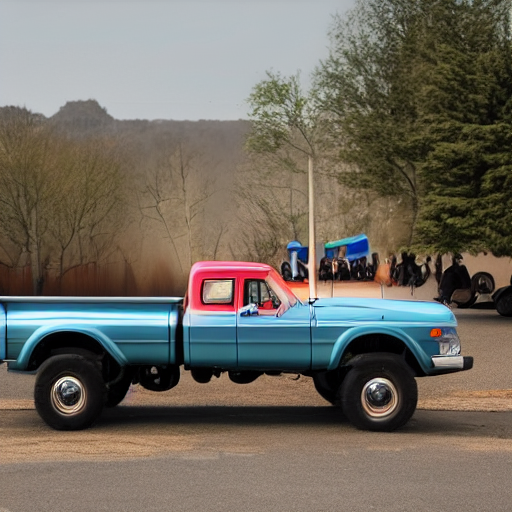

['person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'truck', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person']


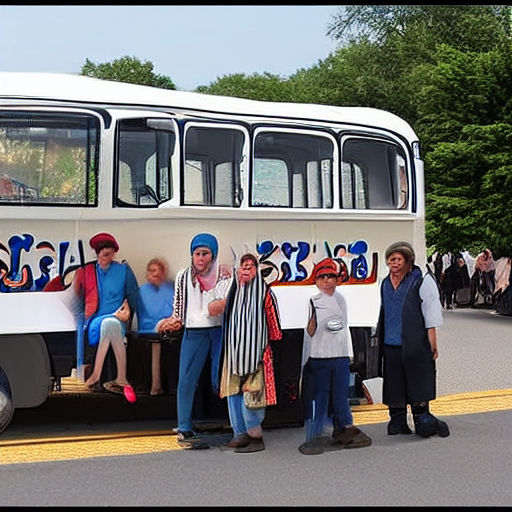

['tie', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'car', 'handbag', 'person', 'bus', 'person', 'person', 'person', 'person', 'person', 'person']


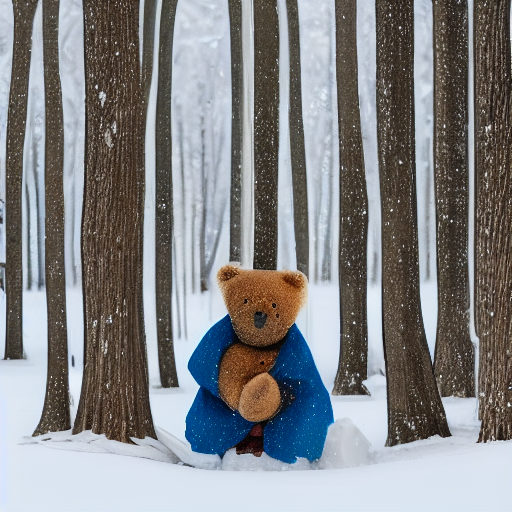

['teddy bear']


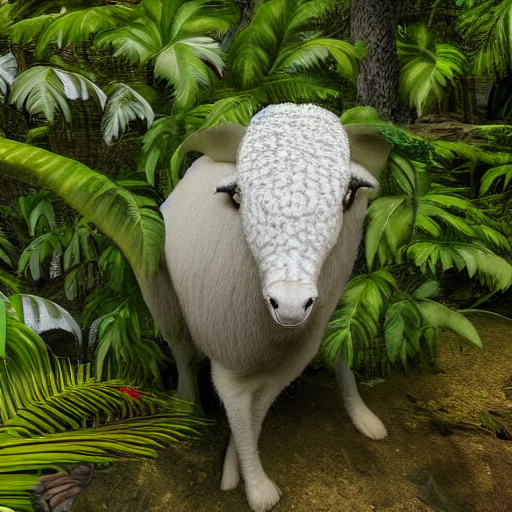

['sheep']


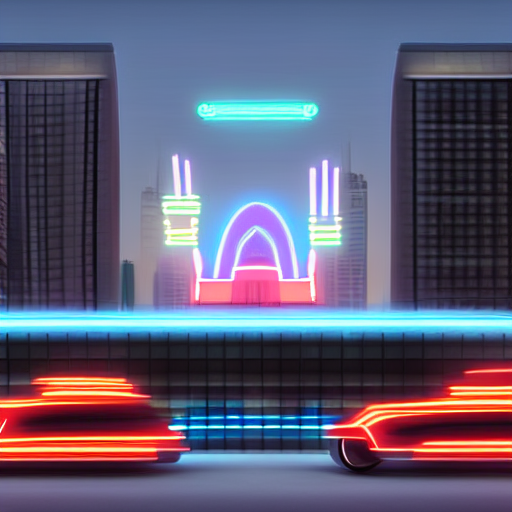

[]


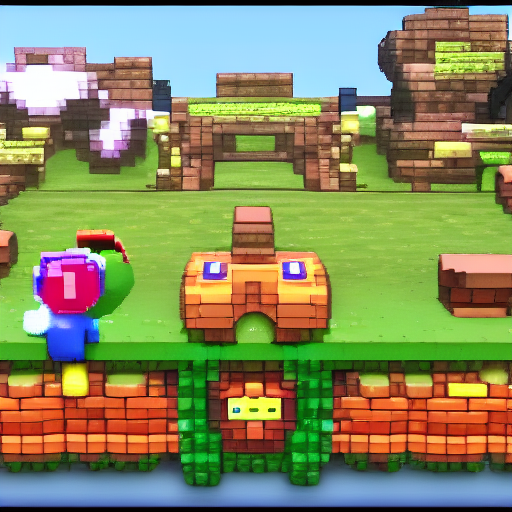

['fire hydrant', 'suitcase']


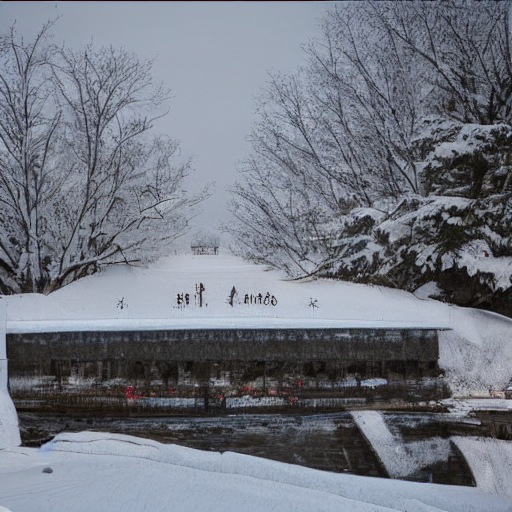

['person', 'person', 'person']


In [11]:
scores = []
for label, prompt in zip(labels, prompts):
    image = generate(prompt)
    display(image)
    objects = detect(image)
    print(objects)
    scores.append(is_correct(objects, label))


In [12]:
print(f"The score for {model_url} is {np.mean(scores)}")

The score for unibuc-cs/ROAITransportationCo_model is 0.5
